#### 資料集下載處，包含train(訓練)、val(驗證)、test(測試)
#### https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### 匯入函式庫

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf

In [3]:
#文件搜索的工具
import glob

#這是一個看迴圈進度條的小工具
from tqdm import tqdm 

#匯入電腦視覺的函式庫，作影像讀取和分析使用
import cv2

In [4]:
#安裝方式
#!pip install opencv-python

In [5]:
#有發生libGL.so.1: cannot open shared object file: No such file or directory 錯誤的話
#!sudo apt update
#!sudo apt install libgl1-mesa-glx -y

### 讀入一張影像測試與檢視

In [6]:
#讀一張影像試試

path_name='chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(path_name,cv2.IMREAD_GRAYSCALE)

#cv2.IMREAD_GRAYSCALE 以灰階的格式來讀取圖片。預設值為cv2.IMREAD_COLOR(讀取 RGB 三個 channels)

#其他的讀取方式：(1)matplotlib、(2)PIL
#import matplotlib.image as mpimg
#img = mpimg.imread(path_name)

#from PIL import Image
#img = Image.open(path_name)

In [7]:

mpl.rcParams['figure.figsize'] = (12,12) #畫布尺寸

img (x_dim, y_dim) and type:  (1152, 1422) uint8


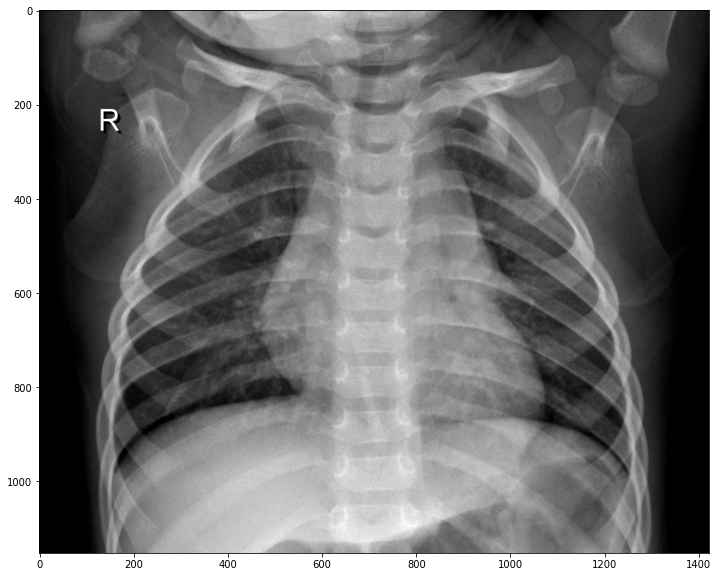

In [8]:
print('img (x_dim, y_dim) and type: ',img.shape, img.dtype)
plt.imshow(img, cmap='gray')

In [9]:
# #補充資料
# #常見的格式讀取方式
# #raw檔
# img = np.fromfile('檔名', dtype='資料型態')

# #dicom檔
# import pydicom
# ds = pydicom.dcmread('檔名')
# img = ds.pixel_array

# #nii檔 (NIfTI格式)
# import nibabel as nib
# ds = nib.load('檔名')
# img = np.squeeze(ds.get_data())  #需使用np.reshape轉成其他的維度

### 定義訓練資料

In [10]:
#欲分類的lable與數量
labels_name = ['NORMAL', 'PNEUMONIA']
num_classes = len(labels_name)

In [11]:
#建立訓練資料所在的路徑位置與對應的label：(filelist, label)
#label為數字，0代表'NORMAL'、1代表'PNEUMONIA'
filelist = []
label = []
for i in labels_name:
    class_num = labels_name.index(i)
    pathfile = glob.glob('chest_xray/train/'+str(i)+'/*.jpeg')
    
    for p in pathfile:
        filelist.append(p)
        label.append(class_num)

In [12]:
print('numbers of img:',len(filelist))

numbers of img: 5216


In [13]:
#影像縮放大小
desired_size = 256

In [14]:
#定義一個縮放影像(img)至指定大小(desired_size)的函數
#等比例縮小，其他地方補黑邊
def squared(img, desired_size):
    old_size = img.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_img

### 開始讀入影像

In [15]:
#先宣告一個指定大小的ndarray
all_data = np.zeros((len(filelist),desired_size,desired_size,3), dtype=np.float32)

In [16]:
#開始讀入影像
for i in tqdm(range(len(filelist))):
    img = cv2.imread(filelist[i], cv2.IMREAD_GRAYSCALE)
    new_img = squared(img, desired_size)

#進行正規化(normalization)，常用除255或z-score
    m = np.mean(new_img)
    s = np.std(new_img)
    t = (new_img-m)/s
#    t=new_img/255

#三個channel可給予不同的處理手法
    all_data[i,:,:,0]=t
    all_data[i,:,:,1]=t
    all_data[i,:,:,2]=t

100%|██████████| 5216/5216 [01:41<00:00, 51.38it/s] 


In [17]:
label=np.array(label)

### 模型匯入與切分資料集

In [18]:
#以test_size的比例分訓練集和驗證集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_data, label, test_size=0.2, random_state=90)  

In [19]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

### 搭建模型

In [20]:
input_layer=tf.keras.layers.Input(shape=(256,256,3))

x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(input_layer)
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(32, activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)

output_layer=tf.keras.layers.Dense(2, activation='softmax')(x)


In [21]:
model=tf.keras.models.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0     

In [22]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range = [1,1.2],
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1)  

### 訓練參數

In [23]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [24]:
#將訓練的模型置放於model_path下的model_name
model_name = 'x_ray'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [25]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

In [26]:
##### 開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=16), epochs=5, 
                        steps_per_epoch=len(x_train)/16, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/5
260/260 [==============================] - 47s 171ms/step - loss: 0.4076 - binary_accuracy: 0.8154 - val_loss: 0.2475 - val_binary_accuracy: 0.9090

Epoch 00001: val_loss improved from inf to 0.24748, saving model to /home/twsscgh953/test_big_file/image_classification/saved_models/x_ray
INFO:tensorflow:Assets written to: /home/twsscgh953/test_big_file/image_classification/saved_models/x_ray/assets
Epoch 2/5
260/260 [==============================] - 40s 153ms/step - loss: 0.3006 - binary_accuracy: 0.8694 - val_loss: 0.1974 - val_binary_accuracy: 0.9253

Epoch 00002: val_loss improved from 0.24748 to 0.19739, saving model to /home/twsscgh953/test_big_file/image_classification/saved_models/x_ray
INFO:tensorflow:Assets written to: /home/twsscgh953/test_big_file/image_classification/saved_models/x_ray/assets
Epoch 3/5
260/260 [==============================] - 43s 166ms/step - loss: 0.2633 - binary_accuracy: 0.8897 - val_loss: 0.1743 - val_binary_accuracy: 0.9301

Epoch 00003: va

## 畫圖

In [27]:
model_history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [28]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['binary_accuracy']
val_acc = model_history.history['val_binary_accuracy']

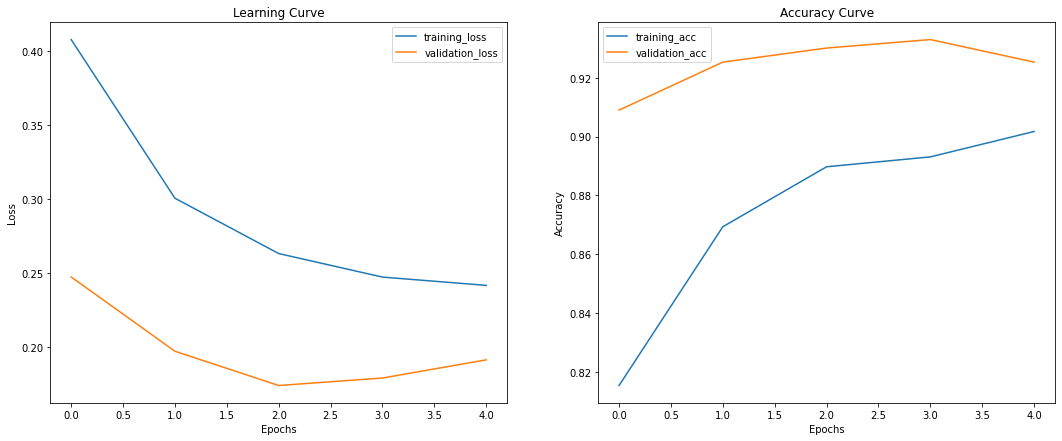

In [29]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()